# Predicting Loan Risk using SparkML on IBM Cloud Pak for Data (ICP4D)

We'll use this notebook to create a machine learning model to predict customer churn. In this notebook we will build the prediction model using the SparkML library.

This notebook walks you through these steps:

- Load and Visualize data set.
- Build a predictive model with SparkML API
- Save the model in the ML repository

## 1.0 Install required packages

There are a couple of Python packages we will use in this notebook. First we make sure the Watson Machine Learning client v3 is removed (its not installed by default) and then install/upgrade the v4 version of the client (this package is installed by default on CP4D).

WML Client: https://wml-api-pyclient-dev-v4.mybluemix.net/#repository

### 1.1 Package Installation

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip uninstall watson-machine-learning-client -y | tail -n 1
!pip install --user watson-machine-learning-client-v4==1.0.95 --upgrade | tail -n 1
!pip install --user pyspark==2.3.3 --upgrade | tail -n 1

### 1.2 Package Imports

In [3]:
import pandas as pd
import numpy as np
import json
import os

# Import the Project Library to read/write project assets
from project_lib import Project
project = Project.access()

## 2.0 Load and Clean data

We'll load our data as a pandas data frame.

**<font color='red'><< FOLLOW THE INSTRUCTIONS BELOW TO LOAD THE DATASET >></font>**

* Highlight the cell below by clicking it.
* Click the `10/01` "Find data" icon in the upper right of the notebook.
* If you are using Virtualized data, begin by choosing the `Files` tab. Then choose your virtualized data (i.e. MYSCHEMA.APPLICANTFINANCIALPERSONALLOANDATA), click `Insert to code` and choose `Insert Pandas DataFrame`.
* If you are using this notebook without virtualized data, add the locally uploaded file `german_credit_data.csv` by choosing the `Files` tab. Then choose the `german_credit_data.csv`. Click `Insert to code` and choose `Insert Pandas DataFrame`.
* The code to bring the data into the notebook environment and create a Pandas DataFrame will be added to the cell below.
* Run the cell


In [4]:
# Place cursor below and insert the Pandas DataFrame for the Credit Risk data
# @hidden_cell
# This connection object is used to access your data and contains your credentials.
# You might want to remove those credentials before you share your notebook.

from project_lib import Project
project = Project.access()
USER1006_JRTAPPLICANTFINANCIALPERSONALLOANSDATA_credentials = project.get_connected_data(name="USER1006.JRTAPPLICANTFINANCIALPERSONALLOANSDATA")

import os, jaydebeapi, pandas as pd

USER1006_JRTAPPLICANTFINANCIALPERSONALLOANSDATA_port = USER1006_JRTAPPLICANTFINANCIALPERSONALLOANSDATA_credentials.get('port', 50000)

USER1006_JRTAPPLICANTFINANCIALPERSONALLOANSDATA_connect_string = '{}://{}:{}/{}'.format(
    'jdbc:db2',
    USER1006_JRTAPPLICANTFINANCIALPERSONALLOANSDATA_credentials['host'],
    USER1006_JRTAPPLICANTFINANCIALPERSONALLOANSDATA_port,
    USER1006_JRTAPPLICANTFINANCIALPERSONALLOANSDATA_credentials['database']
)

if(USER1006_JRTAPPLICANTFINANCIALPERSONALLOANSDATA_credentials.get('ssl','false') == 'true'):
    USER1006_JRTAPPLICANTFINANCIALPERSONALLOANSDATA_connect_string = USER1006_JRTAPPLICANTFINANCIALPERSONALLOANSDATA_connect_string + ':sslConnection=true;'
    if USER1006_JRTAPPLICANTFINANCIALPERSONALLOANSDATA_credentials.get('ssl_certificate', None):
        cert_file_path = os.path.join(os.path.expanduser('~'),'USER1006_JRTAPPLICANTFINANCIALPERSONALLOANSDATA_ssl.cert')
        f = open(cert_file_path, "w")
        f.write(USER1006_JRTAPPLICANTFINANCIALPERSONALLOANSDATA_credentials['ssl_certificate'])
        f.close()
        USER1006_JRTAPPLICANTFINANCIALPERSONALLOANSDATA_connect_string = USER1006_JRTAPPLICANTFINANCIALPERSONALLOANSDATA_connect_string + 'sslCertLocation=' + cert_file_path + ';'

USER1006_JRTAPPLICANTFINANCIALPERSONALLOANSDATA_connection = jaydebeapi.connect(
    'com.ibm.db2.jcc.DB2Driver',
    USER1006_JRTAPPLICANTFINANCIALPERSONALLOANSDATA_connect_string,
    [USER1006_JRTAPPLICANTFINANCIALPERSONALLOANSDATA_credentials['username'],USER1006_JRTAPPLICANTFINANCIALPERSONALLOANSDATA_credentials['password']]
)

# In the following query, the schema and table name are in quotes in order to support case-sensitive names or labels
query = 'SELECT * FROM "USER1006"."JRTAPPLICANTFINANCIALPERSONALLOANSDATA"'
# If your database does not support case-sensitive names or quoted names, you can use the following query:
#query = 'SELECT * FROM USER1006.JRTAPPLICANTFINANCIALPERSONALLOANSDATA'

data_df_4 = pd.read_sql(query, con=USER1006_JRTAPPLICANTFINANCIALPERSONALLOANSDATA_connection)
data_df_4.head()

# Close the database connection with the following code:
# USER1006_JRTAPPLICANTFINANCIALPERSONALLOANSDATA_connection.close()
# To learn more about the jaydebeapi package, please read the documentation: https://pypi.org/project/JayDeBeApi/


,CustomerID,CheckingStatus,CreditHistory,ExistingSavings,InstallmentPlans,ExistingCreditsCount,EmploymentDuration,Sex,CurrentResidenceDuration,OwnsProperty,...,StreetAddress,City,State,PostalCode,LoanDuration,LoanPurpose,LoanAmount,InstallmentPercent,OthersOnLoan,Risk
0,9f0095d0-a4b9-4284-aab4-96620e5a2774,no_checking,prior_payments_delayed,100_to_500,none,2,less_1,male,4,car_other,...,468 Haney Union Apt. 831,Lake Ashleyhaven,ND,58737,25,education,4296,3,none,No Risk
1,ac57d6bc-ffbd-4732-917c-64f08c7a668b,0_to_200,credits_paid_to_date,less_100,none,1,less_1,female,1,real_estate,...,3791 Malik Path Apt. 963,Williamton,OR,97252,13,car_new,1531,2,none,No Risk
2,86fa4c6a-a30f-437a-a0b2-caf5898d6495,no_checking,prior_payments_delayed,500_to_1000,none,1,1_to_4,male,3,savings_insurance,...,978 Valdez Islands,South Julieberg,DC,20021,36,education,6489,4,none,No Risk
3,a9a2761b-c866-4c91-a276-78f0e7bfc2f6,no_checking,credits_paid_to_date,100_to_500,none,1,less_1,male,2,real_estate,...,36881 Ford Bypass Apt. 297,Davisfurt,MS,39083,8,car_used,3357,3,none,No Risk
4,8e020d00-ba6e-42f1-b5fb-8d5c6b2d7cd6,0_to_200,outstanding_credit,greater_1000,none,2,greater_7,female,3,unknown,...,87257 Bianca Estates,Arroyobury,FL,34071,27,appliances,5996,3,none,Risk


We'll use the Pandas naming convention df for our DataFrame. Make sure that the cell below uses the name for the dataframe used above. For the locally uploaded file it should look like df_data_1 or df_data_2 or df_data_x. For the virtualized data case it should look like data_df_1 or data_df_2 or data_df_x.

**<font color='red'><< UPDATE THE VARIABLE ASSIGNMENT TO THE VARIABLE GENERATED ABOVE. >></font>**

In [5]:
# Replace data_df_3 with the variable name generated above.
df = data_df_4

### 2.1 Drop Some Features
Some columns are data attributes that we will not want to use in the machine learning model. We can drop those columns / features:

- CustomerID feature (column)
- Personal Attributes: first_name,last_name,email,street_address,city,state,postal_code 

In [6]:
#Drop some columns, ignoring errors for missing keys in case we use different data sets.
df = df.drop(columns=['CustomerID', 'FirstName', 'LastName', 'Email', 'StreetAddress', 'City', 'State', 'PostalCode', '_ID'], axis=1, errors='ignore')

df.head(5)

,CheckingStatus,CreditHistory,ExistingSavings,InstallmentPlans,ExistingCreditsCount,EmploymentDuration,Sex,CurrentResidenceDuration,OwnsProperty,Age,...,Job,Dependents,Telephone,ForeignWorker,LoanDuration,LoanPurpose,LoanAmount,InstallmentPercent,OthersOnLoan,Risk
0,no_checking,prior_payments_delayed,100_to_500,none,2,less_1,male,4,car_other,41,...,skilled,1,none,yes,25,education,4296,3,none,No Risk
1,0_to_200,credits_paid_to_date,less_100,none,1,less_1,female,1,real_estate,20,...,skilled,1,none,yes,13,car_new,1531,2,none,No Risk
2,no_checking,prior_payments_delayed,500_to_1000,none,1,1_to_4,male,3,savings_insurance,37,...,skilled,1,yes,yes,36,education,6489,4,none,No Risk
3,no_checking,credits_paid_to_date,100_to_500,none,1,less_1,male,2,real_estate,19,...,management_self-employed,1,none,yes,8,car_used,3357,3,none,No Risk
4,0_to_200,outstanding_credit,greater_1000,none,2,greater_7,female,3,unknown,40,...,skilled,1,yes,yes,27,appliances,5996,3,none,Risk


### 2.2 Examine the data types of the features

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5010 entries, 0 to 5009
Data columns (total 21 columns):
CheckingStatus              5010 non-null object
CreditHistory               5010 non-null object
ExistingSavings             5010 non-null object
InstallmentPlans            5010 non-null object
ExistingCreditsCount        5010 non-null int64
EmploymentDuration          5010 non-null object
Sex                         5010 non-null object
CurrentResidenceDuration    5010 non-null int64
OwnsProperty                5010 non-null object
Age                         5010 non-null int64
Housing                     5010 non-null object
Job                         5010 non-null object
Dependents                  5010 non-null int64
Telephone                   5010 non-null object
ForeignWorker               5010 non-null object
LoanDuration                5010 non-null int64
LoanPurpose                 5010 non-null object
LoanAmount                  5010 non-null int64
InstallmentPercen

In [8]:
# Statistics for the columns (features). Set it to all, since default is to describe just the numeric features.
df.describe(include = 'all')

,CheckingStatus,CreditHistory,ExistingSavings,InstallmentPlans,ExistingCreditsCount,EmploymentDuration,Sex,CurrentResidenceDuration,OwnsProperty,Age,...,Job,Dependents,Telephone,ForeignWorker,LoanDuration,LoanPurpose,LoanAmount,InstallmentPercent,OthersOnLoan,Risk
count,5010,5010,5010,5010,5010.000000,5010,5010,5010.000000,5010,5010.000000,...,5010,5010.000000,5010,5010,5010.000000,5010,5010.000000,5010.000000,5010,5010
unique,4,5,5,3,NaN,5,2,NaN,4,NaN,...,4,NaN,2,2,NaN,11,NaN,NaN,3,2
top,no_checking,prior_payments_delayed,less_100,none,NaN,1_to_4,male,NaN,savings_insurance,NaN,...,skilled,NaN,none,yes,NaN,car_new,NaN,NaN,none,No Risk
freq,1995,1690,1863,3523,NaN,1473,3111,NaN,1667,NaN,...,3409,NaN,2949,4886,NaN,948,NaN,NaN,4181,3339
mean,NaN,NaN,NaN,NaN,1.465669,NaN,NaN,2.853892,NaN,35.931138,...,NaN,1.164271,NaN,NaN,21.400998,NaN,3478.095808,2.981836,NaN,NaN
std,NaN,NaN,NaN,NaN,0.565282,NaN,NaN,1.114797,NaN,10.645762,...,NaN,0.370559,NaN,NaN,11.157929,NaN,2488.056183,1.126581,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,19.000000,...,NaN,1.000000,NaN,NaN,4.000000,NaN,250.000000,1.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,2.000000,NaN,28.000000,...,NaN,1.000000,NaN,NaN,13.000000,NaN,1326.250000,2.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,3.000000,NaN,36.000000,...,NaN,1.000000,NaN,NaN,21.000000,NaN,3237.000000,3.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,4.000000,NaN,44.000000,...,NaN,1.000000,NaN,NaN,29.000000,NaN,5354.750000,4.000000,NaN,NaN


We see that the loan amounts range from 250 to ~11,600. That the age range for applicants is between 19 and 74. etc.

### 2.3 Check for missing data

We should check if there are missing values in our dataset. There are various ways we can address this issue:

- Drop records with missing values 
- Fill in the missing value with one of the following strategies: Zero, Mean of the values for the column, Random value, etc).

In [9]:
# Check if we have any NaN values and see which features have missing values that should be addressed
print(df.isnull().values.any())
df.isnull().sum()

False


CheckingStatus              0
CreditHistory               0
ExistingSavings             0
InstallmentPlans            0
ExistingCreditsCount        0
EmploymentDuration          0
Sex                         0
CurrentResidenceDuration    0
OwnsProperty                0
Age                         0
Housing                     0
Job                         0
Dependents                  0
Telephone                   0
ForeignWorker               0
LoanDuration                0
LoanPurpose                 0
LoanAmount                  0
InstallmentPercent          0
OthersOnLoan                0
Risk                        0
dtype: int64

Depending on which version of the dataset that you used, there may be no missing values. If there are any missing values from the output above, the sample below would be one approach to handle this issue by imputing the values for the column that reported missing data (i.e the `CurrentResidenceDuration` column in the code as an example):


In [10]:
## Handle missing values for nan_column (CurrentResidenceDuration)
#from sklearn.impute import SimpleImputer

## Find the column number for TotalCharges (starting at 0).
#target_idx = df.columns.get_loc("CurrentResidenceDuration")
#imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
#df.iloc[:, target_idx] = imputer.fit_transform(df.iloc[:, target_idx].values.reshape(-1, 1))
#df.iloc[:, target_idx] = pd.Series(df.iloc[:, target_idx])

### 2.4 Categorize Features

We will categorize some of the columns / features based on wether they are categorical values or continuous (i.e numerical) values. We will use this in later sections to build visualizations.

In [11]:
TARGET_LABEL_COLUMN_NAME = 'Risk'
columns_idx = np.s_[0:] # Slice of first row(header) with all columns.
first_record_idx = np.s_[0] # Index of first record

string_fields = [type(fld) is str for fld in df.iloc[first_record_idx, columns_idx]] # All string fields
all_features = [x for x in df.columns if x != TARGET_LABEL_COLUMN_NAME]
categorical_columns = list(np.array(df.columns)[columns_idx][string_fields])
categorical_features = [x for x in categorical_columns if x != TARGET_LABEL_COLUMN_NAME]
continuous_features = [x for x in all_features if x not in categorical_features]

print('All Features: ', all_features)
print('\nCategorical Features: ', categorical_features)
print('\nContinuous Features: ', continuous_features)
print('\nAll Categorical Columns: ', categorical_columns)

All Features:  ['CheckingStatus', 'CreditHistory', 'ExistingSavings', 'InstallmentPlans', 'ExistingCreditsCount', 'EmploymentDuration', 'Sex', 'CurrentResidenceDuration', 'OwnsProperty', 'Age', 'Housing', 'Job', 'Dependents', 'Telephone', 'ForeignWorker', 'LoanDuration', 'LoanPurpose', 'LoanAmount', 'InstallmentPercent', 'OthersOnLoan']

Categorical Features:  ['CheckingStatus', 'CreditHistory', 'ExistingSavings', 'InstallmentPlans', 'EmploymentDuration', 'Sex', 'OwnsProperty', 'Housing', 'Job', 'Telephone', 'ForeignWorker', 'LoanPurpose', 'OthersOnLoan']

Continuous Features:  ['ExistingCreditsCount', 'CurrentResidenceDuration', 'Age', 'Dependents', 'LoanDuration', 'LoanAmount', 'InstallmentPercent']

All Categorical Columns:  ['CheckingStatus', 'CreditHistory', 'ExistingSavings', 'InstallmentPlans', 'EmploymentDuration', 'Sex', 'OwnsProperty', 'Housing', 'Job', 'Telephone', 'ForeignWorker', 'LoanPurpose', 'OthersOnLoan', 'Risk']


### 2.5 Visualize data

Data visualization can be used to find patterns, detect outliers, understand distribution and more. We can use graphs such as:

- Histograms, boxplots, etc: To find distribution / spread of our continuous variables.
- Bar charts: To show frequency in categorical values.


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

%matplotlib inline
sns.set(style="darkgrid")
sns.set_palette("hls", 3)

First, we get a high level view of the distribution of Risk. What percentage of applicants in our dataset represent Risk vs No Risk.

Risk
No Risk    3339
Risk       1671
dtype: int64


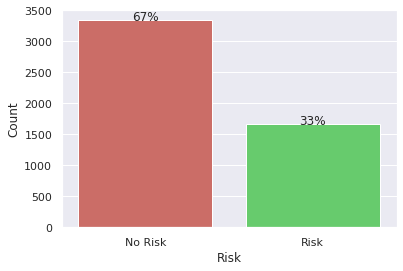

In [13]:
print(df.groupby([TARGET_LABEL_COLUMN_NAME]).size())
risk_plot = sns.countplot(data=df, x=TARGET_LABEL_COLUMN_NAME, order=df[TARGET_LABEL_COLUMN_NAME].value_counts().index)
plt.ylabel('Count')
for p in risk_plot.patches:
    height = p.get_height()
    risk_plot.text(p.get_x()+p.get_width()/2., height + 1,'{0:.0%}'.format(height/float(len(df))),ha="center") 
plt.show()

We can get use frequency counts charts to get an understanding of the categorical features relative to Risk

- We can see in the `CheckingStatus` visualization, loan applications with 'no_checking' have a higher occurence of Risk versus loans with other checking status values.
- We can see in the `CreditHistory` visualization, the loans that have no credits (i.e. all credit has been paid back) have no occurences of Risk (at least in this dataset). There is a small count of Risk for those applicants that have paid back all credit to date. And there is a higher frequency or ratio of Risk for applicants that have existing credit (i.e outstanding credit).

### NOTE: The creation of these plots can take several minutes

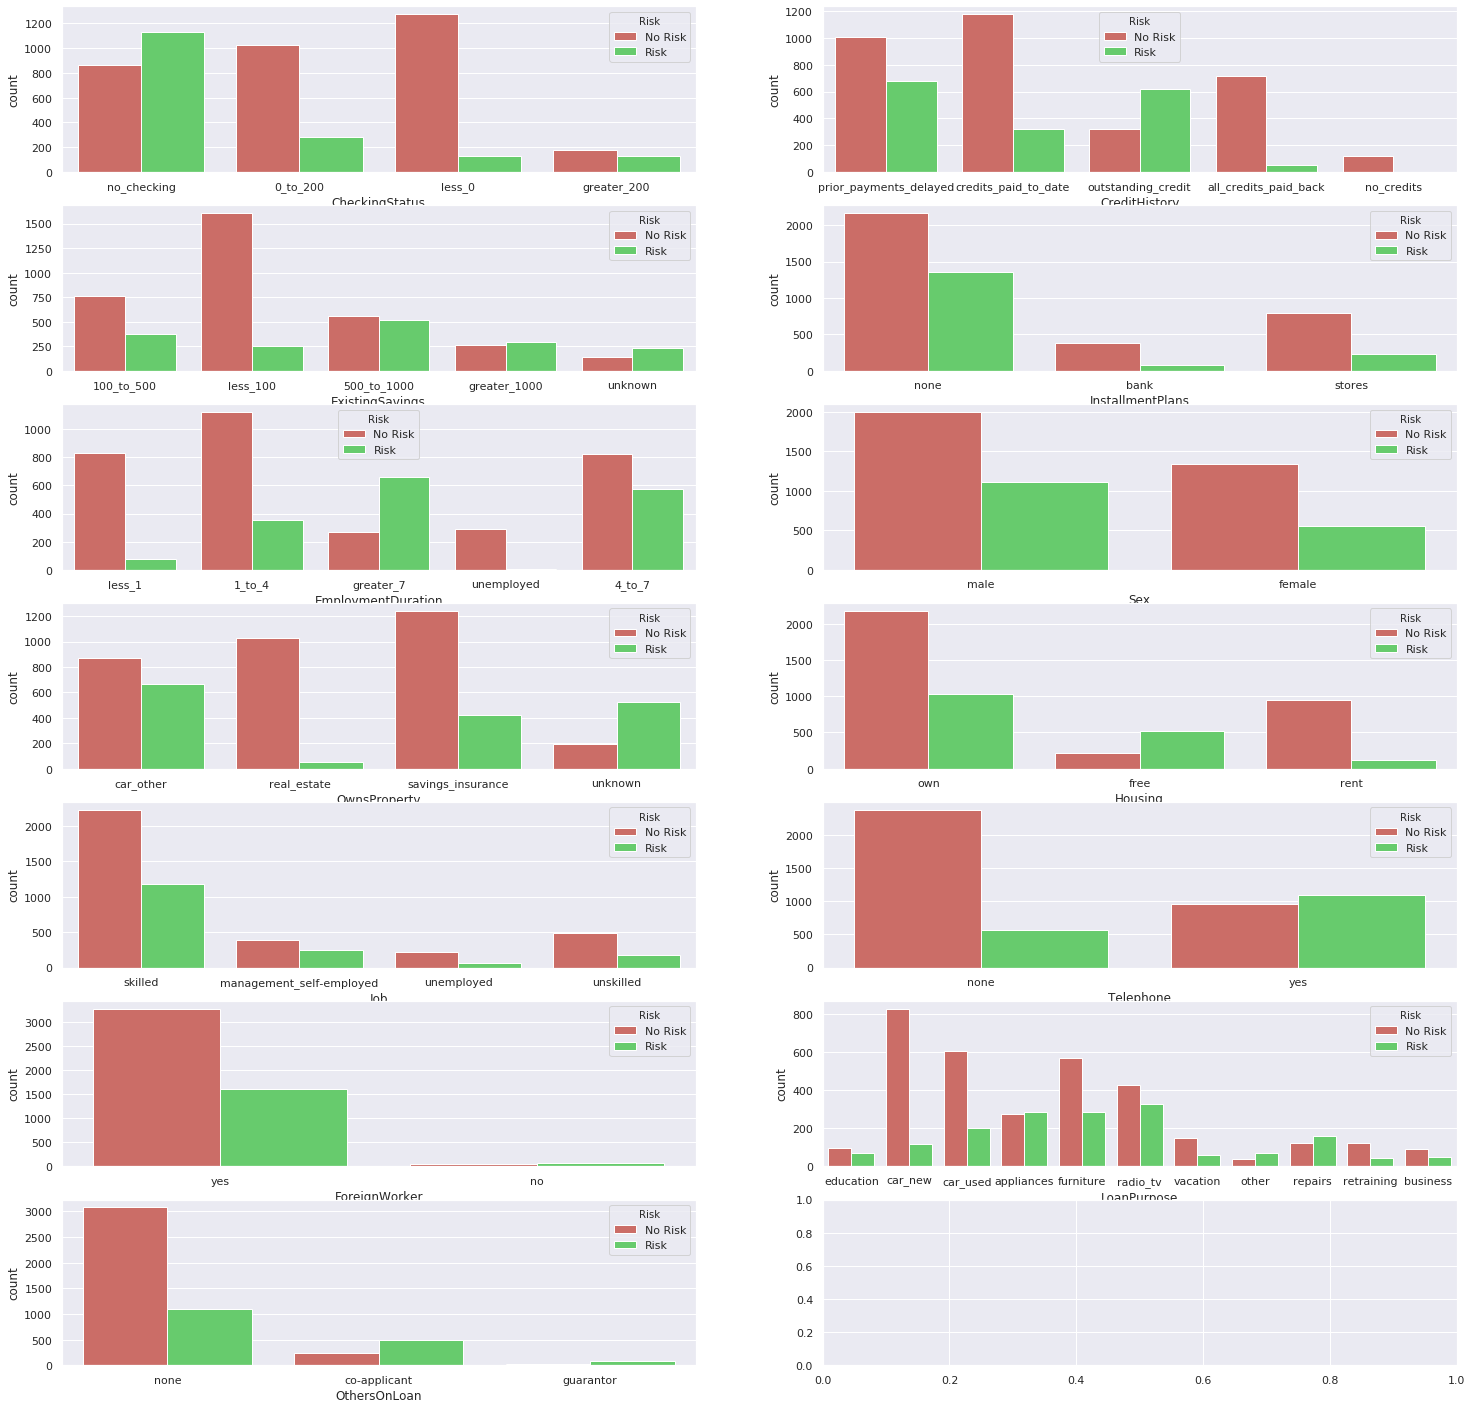

In [14]:
# Categorical feature count plots
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12), (ax13, ax14)) = plt.subplots(7, 2, figsize=(25, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14 ]

for i in range(len(categorical_features)):
    sns.countplot(x = categorical_features[i], hue=TARGET_LABEL_COLUMN_NAME, data=df, ax=ax[i])
    

We can get use histrogram and boxplots to get an understanding of the distribution of our continuous / numerical features relative to Risk.

- We can see that for loans that have Risk, the `InstallmentPercent` tends to be higher (i.e. the loans with Risk tend to have loan amounts with higher percentage of the loan applicants disposable income).
- We can see that those with 'No Risk' seem to be those with fewer existing credit loans at the bank (`ExistingCreditCount`)


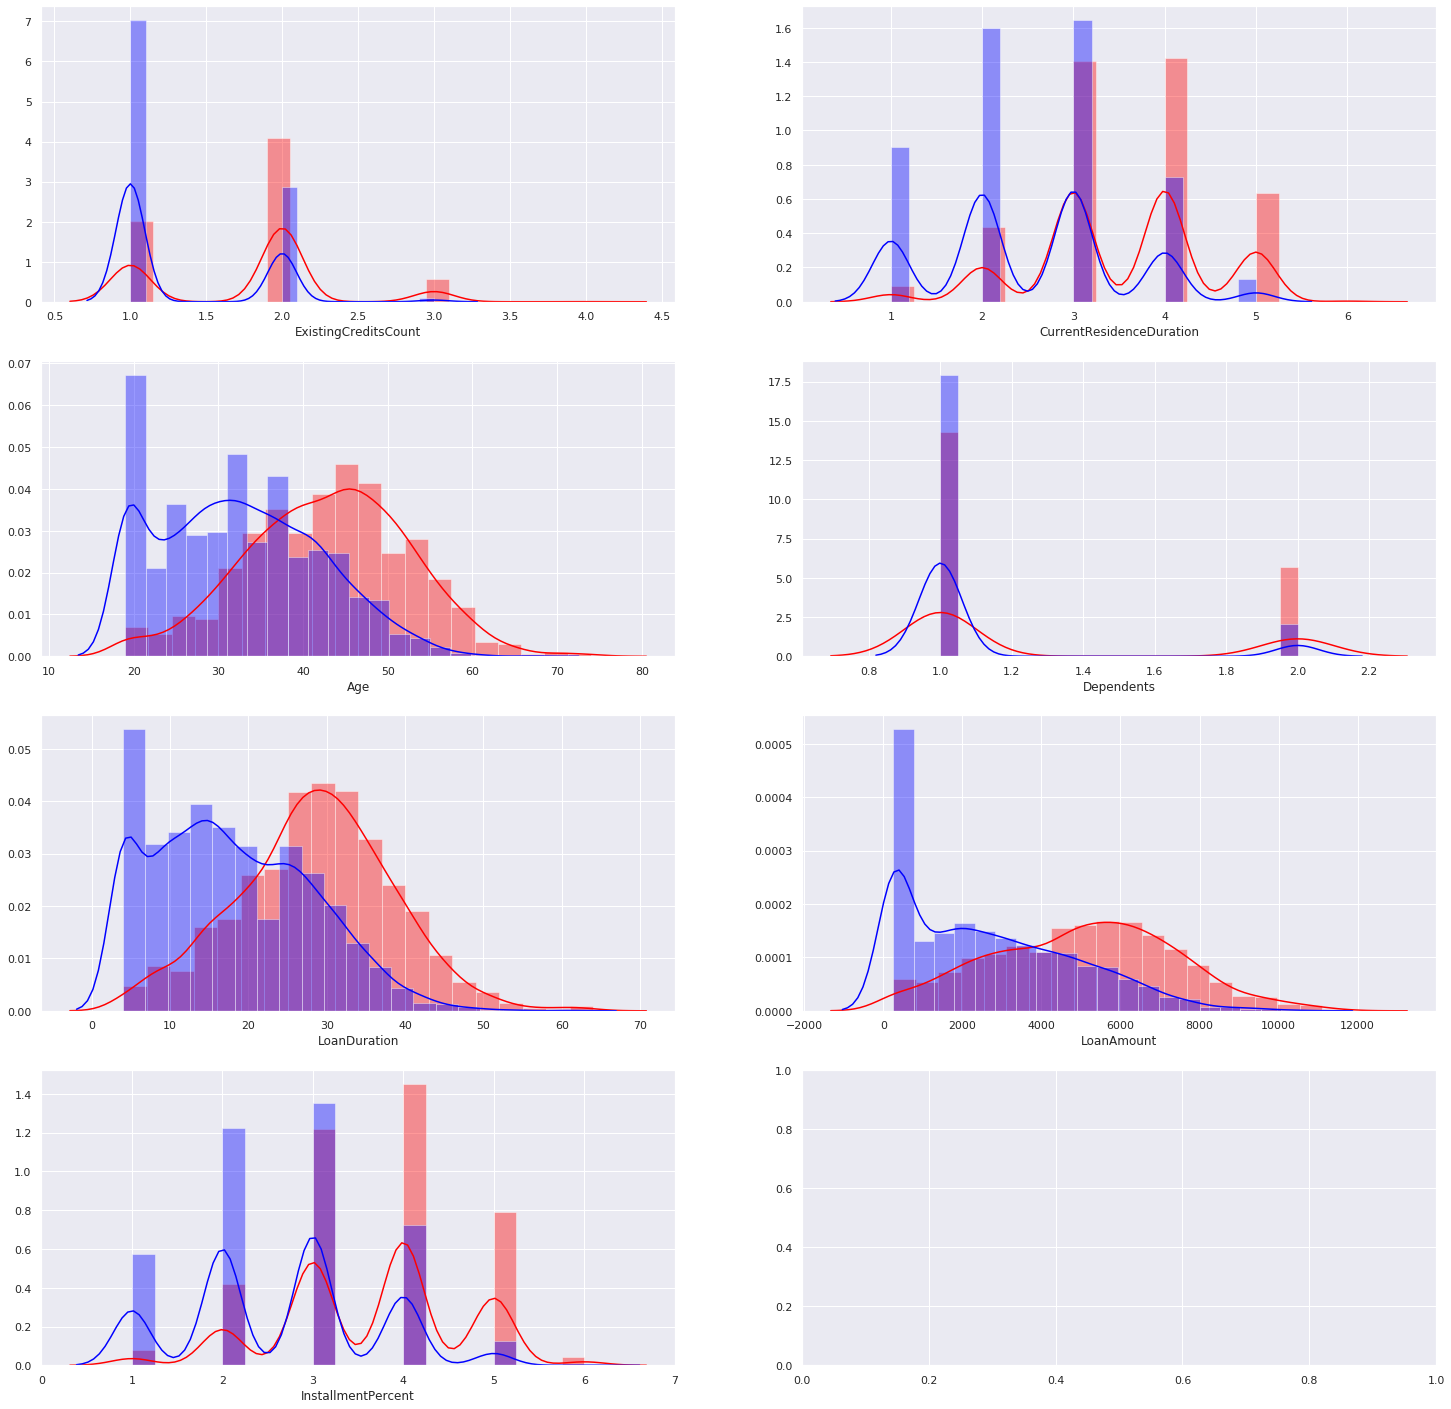

In [15]:
# Continuous feature histograms.
f, ((ax1, ax2),(ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(25, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
for i in range(len(continuous_features)):
    #sns.distplot(df[continuous_features[i]], bins=20, color="blue", hist=True, ax=ax[i])
    sns.distplot(df[df.Risk == 'Risk'][continuous_features[i]], bins=20, color="Red", hist=True, ax=ax[i])
    sns.distplot(df[df.Risk == 'No Risk'][continuous_features[i]], bins=20, color="blue", hist=True, ax=ax[i])


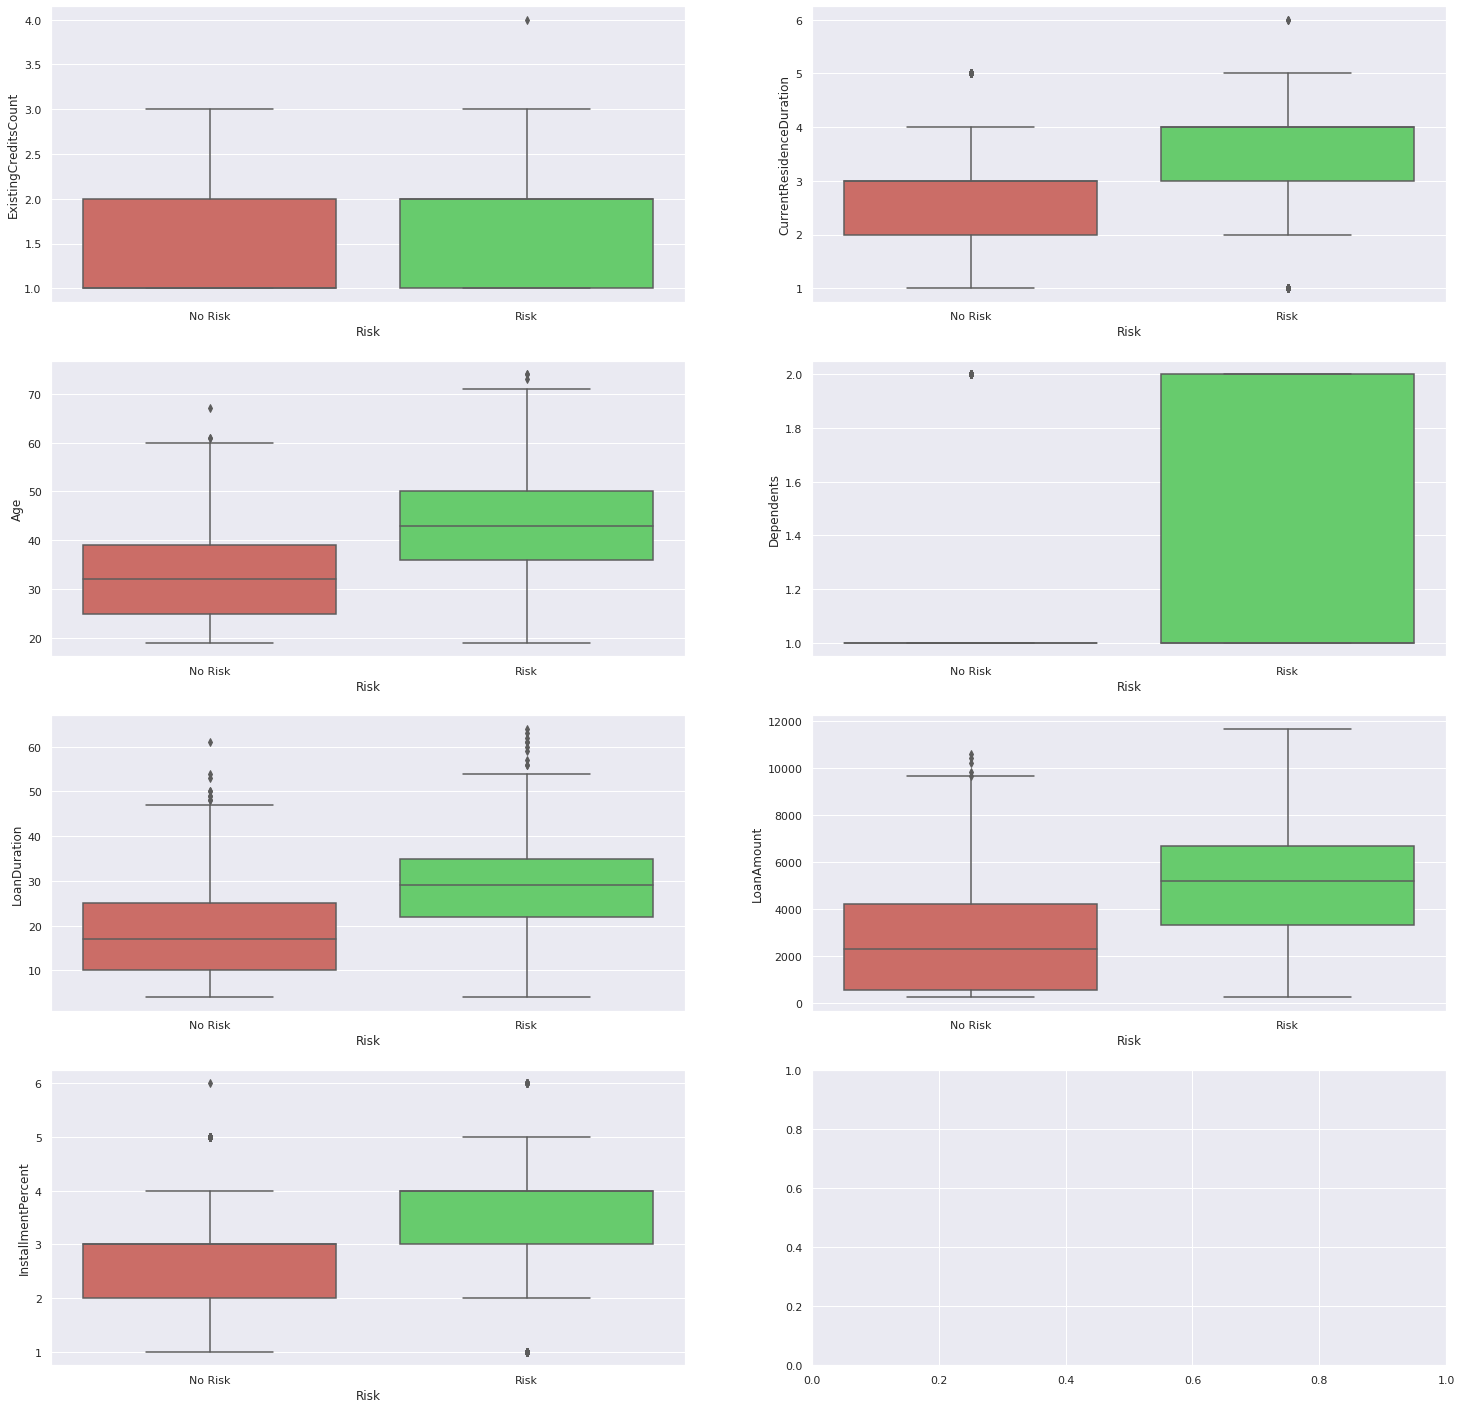

In [16]:
# Plot boxplots of numerical columns. More variation in the boxplot implies higher significance. 
f, ((ax1, ax2),(ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(25, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
for i in range(len(continuous_features)):
    sns.boxplot(x = TARGET_LABEL_COLUMN_NAME, y = continuous_features[i], data=df, ax=ax[i])


## 3.0 Create a model

Now we can create our machine learning model. You could use the insights / intuition gained from the data visualization steps above to what kind of model to create or which features to use. We will create a simple classification model.

In [17]:
from pyspark.sql import SparkSession
import pandas as pd
import json

spark = SparkSession.builder.getOrCreate()
df_data = spark.createDataFrame(df)
df_data.head()

Row(CheckingStatus='no_checking', CreditHistory='prior_payments_delayed', ExistingSavings='100_to_500', InstallmentPlans='none', ExistingCreditsCount=2, EmploymentDuration='less_1', Sex='male', CurrentResidenceDuration=4, OwnsProperty='car_other', Age=41, Housing='own', Job='skilled', Dependents=1, Telephone='none', ForeignWorker='yes', LoanDuration=25, LoanPurpose='education', LoanAmount=4296, InstallmentPercent=3, OthersOnLoan='none', Risk='No Risk')

### 3.1 Split the data into training and test sets

In [18]:
spark_df = df_data
(train_data, test_data) = spark_df.randomSplit([0.8, 0.2], 24)

print("Number of records for training: " + str(train_data.count()))
print("Number of records for evaluation: " + str(test_data.count()))

Number of records for training: 4048
Number of records for evaluation: 962


### 3.2 Examine the Spark DataFrame Schema
Look at the data types to determine requirements for feature engineering

In [19]:
spark_df.printSchema()

root
 |-- CheckingStatus: string (nullable = true)
 |-- CreditHistory: string (nullable = true)
 |-- ExistingSavings: string (nullable = true)
 |-- InstallmentPlans: string (nullable = true)
 |-- ExistingCreditsCount: long (nullable = true)
 |-- EmploymentDuration: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- CurrentResidenceDuration: long (nullable = true)
 |-- OwnsProperty: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- Housing: string (nullable = true)
 |-- Job: string (nullable = true)
 |-- Dependents: long (nullable = true)
 |-- Telephone: string (nullable = true)
 |-- ForeignWorker: string (nullable = true)
 |-- LoanDuration: long (nullable = true)
 |-- LoanPurpose: string (nullable = true)
 |-- LoanAmount: long (nullable = true)
 |-- InstallmentPercent: long (nullable = true)
 |-- OthersOnLoan: string (nullable = true)
 |-- Risk: string (nullable = true)



### 3.3 Use StringIndexer to encode a string column of labels to a column of label indices

We are using the Pipeline package to build the development steps as pipeline. 
We are using StringIndexer to handle categorical / string features from the dataset. StringIndexer encodes a string column of labels to a column of label indices

We then use VectorAssembler to asemble these features into a vector. Pipelines API requires that input variables are passed in  a vector

In [20]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler, SQLTransformer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline, Model

#Create StringIndexer columns whose names are same as the categorical column with an appended _IX.
categorical_num_features = [x + '_IX' for x in categorical_features]
si_list = [StringIndexer(inputCol=nm_in, outputCol=nm_out) for nm_in, nm_out in zip(categorical_features, categorical_num_features)]

In [21]:
# Encode our target label column (i.e Risk or No Risk). 
# Also, creates an label convert which performs an inverse map to get back a 'Risk' or 'No Risk' label from the encoded prediction.
si_label = StringIndexer(inputCol=TARGET_LABEL_COLUMN_NAME, outputCol="label").fit(spark_df)
label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=si_label.labels)

In [22]:
# Construct all encoded categorical features plus continuous features into a vector
va_features = VectorAssembler(inputCols=categorical_num_features + continuous_features, outputCol="features")

### 3.4 Create a pipeline, and fit a model using RandomForestClassifier 
Assemble all the stages into a pipeline. We don't expect a clean linear regression, so we'll use RandomForestClassifier to find the best decision tree for the data.

The pipeline will consist of: the feature string indexing step, the label string indexing Step, vector sssembly of all features step, random forest classifier, label converter step, and ending with a feature filter step.

**Note: If you want filter features from model output, you could use the feature filter by replacing `*` with feature names to be retained in SQLTransformer statement.**

In [23]:
classifier = RandomForestClassifier(featuresCol="features")
feature_filter = SQLTransformer(statement="SELECT * FROM __THIS__")
pipeline = Pipeline(stages= si_list + [si_label, va_features, classifier, label_converter, feature_filter])

model = pipeline.fit(train_data)

In [24]:
predictions = model.transform(test_data)
evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction",  metricName='areaUnderROC')
area_under_curve = evaluatorDT.evaluate(predictions)

evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction",  metricName='areaUnderPR')
area_under_PR = evaluatorDT.evaluate(predictions)
#default evaluation is areaUnderROC
print("areaUnderROC = %g" % area_under_curve, "areaUnderPR = %g" % area_under_PR)

areaUnderROC = 0.712264 areaUnderPR = 0.664103


### 3.5 evaluate more metrics by exporting them into pandas and numpy

In [25]:
from sklearn.metrics import classification_report
y_pred = predictions.toPandas()['prediction']
y_pred = ['Risk' if pred == 1.0 else 'No Risk' for pred in y_pred]
y_test = test_data.toPandas()[TARGET_LABEL_COLUMN_NAME]
print(classification_report(y_test, y_pred, target_names=['Risk', 'No Risk']))

              precision    recall  f1-score   support

        Risk       0.78      0.92      0.85       636
     No Risk       0.77      0.50      0.61       326

    accuracy                           0.78       962
   macro avg       0.78      0.71      0.73       962
weighted avg       0.78      0.78      0.77       962



## 4.0 Save the model and test data

Now the model can be saved for future deployment. The model will be saved using the Watson Machine Learning client, to a deployment space.

### 4.1 Save the model to ICP4D local Watson Machine Learning

<font color='red'>Replace the `username` and `password` values of `************` with your Cloud Pak for Data `username` and `password`. The value for `url` should match the `url` for your Cloud Pak for Data cluster, which you can get from the browser address bar (be sure to include the 'https://'.</font> The credentials should look something like this (these are example values, not the ones you will use):

`
wml_credentials = {
                   "url": "https://zen.clusterid.us-south.containers.appdomain.cloud",
                   "username": "cp4duser",
                   "password" : "cp4dpass",
                   "instance_id": "wml_local",
                   "version" : "2.5.0"
                  }
`
#### NOTE: Make sure that there is no trailing forward slash `/` in the `url`

In [26]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

wml_credentials = {
                   "url": "https://zen2-cpd-zen2.aida-cpd3-dal10-b3c-56x-f2c6cdc6801be85fd188b09d006f13e3-0001.us-south.containers.appdomain.cloud/",
                   "username": "jrtorres",
                   "password" : "***************",
                   "instance_id": "wml_local",
                   "version" : "3.0.0"
                  }

wml_client = WatsonMachineLearningAPIClient(wml_credentials)


In [27]:
wml_client.spaces.list()

------------------------------------  -------------------------  ------------------------
GUID                                  NAME                       CREATED
f277dfae-8d22-477e-92a7-7e5f3bdf7898  CreditRiskDeploymentSpace  2020-09-08T20:32:57.929Z
------------------------------------  -------------------------  ------------------------


### Use the desired space as the `default_space`

The deployment space ID will be looked up based on the name specified above. If you do not receive a space GUID as an output to the next cell, do not proceed until you have created a deployment space.

**<font color='red'><< UPDATE THE VARIABLE 'MODEL_NAME' TO A UNIQUE NAME>></font>**

**<font color='red'><< UPDATE THE VARIABLE 'DEPLOYMENT_SPACE_NAME' TO THE NAME OF THE DEPLOYMENT SPACE CREATED PREVIOUSLY>></font>**

In [28]:
MODEL_NAME = "ChurnSparkModelV1"
DEPLOYMENT_SPACE_NAME = "CreditRiskDeploymentSpace"

In [29]:
wml_client.spaces.list()
all_spaces = wml_client.spaces.get_details()['resources']
space_id = None
for space in all_spaces:
    if space['entity']['name'] == DEPLOYMENT_SPACE_NAME:
        space_id = space["metadata"]["guid"]
        print("\nDeployment Space GUID: ", space_id)

if space_id is None:
    print("WARNING: Your space does not exist. Create a deployment space before proceeding to the next cell.")
    #space_id = client.spaces.store(meta_props={client.spaces.ConfigurationMetaNames.NAME: space_name})["metadata"]["guid"]

------------------------------------  -------------------------  ------------------------
GUID                                  NAME                       CREATED
f277dfae-8d22-477e-92a7-7e5f3bdf7898  CreditRiskDeploymentSpace  2020-09-08T20:32:57.929Z
------------------------------------  -------------------------  ------------------------

Deployment Space GUID:  f277dfae-8d22-477e-92a7-7e5f3bdf7898


In [30]:
# Now set the default space to the GUID for your deployment space. If this is successful, you will see a 'SUCCESS' message.
wml_client.set.default_space(space_id)


'SUCCESS'

#### (Optional) Remove Existing Model and Deployment

In [31]:
#wml_models = wml_client.repository.get_model_details()
#model_uid = None
#for model_in in wml_models['resources']:
#    if MODEL_NAME == model_in['entity']['name']:
#        model_uid = model_in['metadata']['guid']
#        print('Deleting model id', model_uid)
#        wml_client.repository.delete(model_uid)
#        break
#
# wml_client.repository.list_models()

#### Save the Model

In [32]:
metadata = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME,
    wml_client.repository.ModelMetaNames.TYPE: 'mllib_2.3',
    wml_client.repository.ModelMetaNames.RUNTIME_UID: 'spark-mllib_2.3',
}

published_model_details = wml_client.repository.store_model(model, metadata, training_data=df_data,  pipeline=pipeline)
model_uid = wml_client.repository.get_model_uid(published_model_details)

print(json.dumps(published_model_details, indent=3))


{
   "metadata": {
      "name": "ChurnSparkModelV1",
      "guid": "f9a9d722-e00e-4f83-9bb7-f606f0863675",
      "id": "f9a9d722-e00e-4f83-9bb7-f606f0863675",
      "modified_at": "2020-09-10T03:57:44.002Z",
      "created_at": "2020-09-10T03:57:40.002Z",
      "owner": "1000331006",
      "href": "/v4/models/f9a9d722-e00e-4f83-9bb7-f606f0863675?space_id=f277dfae-8d22-477e-92a7-7e5f3bdf7898",
      "space_id": "f277dfae-8d22-477e-92a7-7e5f3bdf7898"
   },
   "entity": {
      "name": "ChurnSparkModelV1",
      "training_data_references": [
         {
            "location": {
               "bucket": "not_applicable"
            },
            "type": "fs",
            "connection": {
               "access_key_id": "not_applicable",
               "secret_access_key": "not_applicable",
               "endpoint_url": "not_applicable"
            },
            "schema": {
               "id": "1",
               "type": "struct",
               "fields": [
                  {
         

In [33]:
# Use this cell to do any cleanup of previously created models and deployments
wml_client.repository.list_models()
wml_client.deployments.list()

# wml_client.repository.delete('GUID of stored model')
# wml_client.deployments.delete('GUID of deployed model')

------------------------------------  ---------------------------------------------------------  ------------------------  --------------
GUID                                  NAME                                                       CREATED                   TYPE
f9a9d722-e00e-4f83-9bb7-f606f0863675  ChurnSparkModelV1                                          2020-09-10T03:57:40.002Z  mllib_2.3
f6417835-4833-4030-91e5-6eaec4b531e5  ChurnAutoAIExpv1 - P4 GradientBoostingClassifierEstimator  2020-09-10T01:52:01.002Z  wml-hybrid_0.1
------------------------------------  ---------------------------------------------------------  ------------------------  --------------
----  ----  -----  -------  -------------
GUID  NAME  STATE  CREATED  ARTIFACT_TYPE
----  ----  -----  -------  -------------


## 5.0 Save Test Data

We will save the test data we used to evaluate the model to our project. Although not required, this will make it easier to run batch tests later on.

In [34]:
write_score_CSV=test_data.toPandas().drop([TARGET_LABEL_COLUMN_NAME], axis=1)
write_score_CSV.to_csv('/project_data/data_asset/GermanCreditRiskSparkMLBatchScore.csv', sep=',', index=False)
#project.save_data('GermanCreditRiskSparkMLBatchScore.csv', write_score_CSV.to_csv())

write_eval_CSV=test_data.toPandas()
write_eval_CSV.to_csv('/project_data/data_asset/GermanCreditRiskSparkMLEval.csv', sep=',', index=False)
#project.save_data('GermanCreditRiskSparkMLEval.csv', write_eval_CSV.to_csv())